# Drought analysis

This chapter provides a Discharge and Drought Analysis using observed, simulated historical and simulated future discharge data. A key component of this analysis is the application of statistical methods, particularly Metastatistical Extreme Value (MEV) analysis. This uses various extreme value distributions to understand and predict extreme events, such as droughts. The distributions used here are the Generalized Extreme Value (GEV), Gumbel, and Weibull distributions.

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json
import math

# Niceties
from rich import print
from IPython.display import display, HTML

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.forcing

In [3]:
# For MEV
from scipy.stats import genextreme, gumbel_r, weibull_min

In [5]:
# Import drought classification functions
from critical_days_module import droughts, classify_discharge_status

Exported functions to: critical_days_module.py


In [6]:
# Load Data
#simulated
historic = pd.read_csv("Historic_discharge.csv", parse_dates=["date"], index_col="date")
future = pd.read_csv("Future_scenarios_discharge.csv", parse_dates=["date"], index_col="date")

#observed
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Observed")
xr_observed = xr.Dataset({"Observed": ("time", discharge_series.values)}, coords={"time": discharge_series.index})


In [7]:
# Convert to xarray
def df_to_xarray(df):
    return xr.Dataset({col: ("time", df[col].values) for col in df.columns}, coords={"time": df.index})

xr_historic = df_to_xarray(historic)
xr_future = df_to_xarray(future)

## Metastatistical Extreme Value (MEV) Analysis
The calculate\_mev function is specifically designed to perform Metastatistical Extreme Value (MEV) analysis. MEV analysis is generally used to fit extreme value distributions to annual maximum or minimum data. With this fit, one can gain an understanding of the behavior of extreme events (Marra et al., 2018).

MEV is used because it offers a more flexible approach to data analysis. Traditional extreme value theory methods often rely on the assumption of large samples from independent and identically distributed data (Marra et al., 2018), which is not available for the Rhine at Iffezheim. Given that the observed dataset spans only seven years, MEV is particularly well-suited. Because for records as brief as five years, the uncertainty of MEV analysis remains below 30% (Marra et al., 2018).

### Generalized Extreme Value (GEV) Distribution
The GEV distribution represents a family of continuous probability distributions that includes the Gumbel, Fréchet, and reverse Weibull families. It is widely used for modeling extreme events, such as maximum or minimum  of observed values (Marra et al., 2018). It is also considered a popular alternative for the estimation of extreme values without assumptions (Wang et al., 2014).

The Cumulative Distribution Function (CDF) of the Generalized Extreme Value (GEV) distribution can be expressed as (Wang et al., 2014):

$$
F_G(z) = \exp \left( - \left[ 1 + \xi \left( \frac{z - \mu}{\sigma} \right) \right]^{-1/\xi} \right)
$$

Where:

- $z$ is the annual maximum discharge (in m³/s), derived from observed or simulated (with ERA 5 forcing) daily discharge time series. One value per year is retained for GEV fitting.
- $\mu$ denotes the location parameter, showing the average trend of the annual maximum discharge.
- $\sigma$ denotes the scale parameter, which shows how much the annual maximum discharge values differ from each other.
- $\xi$ denotes the shape parameter, which determines the tail behavior of the distribution:
  - $\xi > 0$: Fréchet type  
  - $\xi = 0$: Gumbel type  
  - $\xi < 0$: Reverse Weibull type


### Gumbel Distribution
The Gumbel distribution is a specific case of the GEV distribution ($\xi = 0$ (Wang et al., 2014).

The CDF of the Gumbel distribution can be defined as (Wang et al., 2014):

$$
F_1(v) = \exp \left( - \exp \left[ - \frac{(v - \mu)}{\sigma} \right] \right)
$$

Where:

- $F_1(v)$ is the cumulative probability of observing an annual maximum discharge less than or equal to $v$.
- $v$ is the annual maximum discharge (in m³/s), derived from observed or simulated (with ERA 5 forcing) daily discharge time series. One value per year is retained for Gumbel fitting.
- $\mu$ denotes the location parameter, showing the average trend of the annual maximum discharge.
- $\sigma$ denotes the scale parameter, which shows how much the annual maximum discharge values differ from each other.

### Weibull Distribution
The Weibull distribution plays a specific role within the MEV framework, primarily for modeling "ordinary events" (Marra et al., 2018).

The Weibull cumulative distribution function can be written as (Marra et al., 2018): 

$$
F(y) = 1 - \exp \left( - \left( \frac{y}{\lambda} \right)^k \right)
$$

Where:

- $F(y)$ is the cumulative probability of observing a daily discharge less than or equal to $y$.
- $y$ represents the ordinary (non-extreme) daily discharge value in m³/s, derived from the observed or simulated (with ERA 5 forcing) daily discharge time series.
- $\lambda$ denotes the scale parameter, which controls how wide or narrow the daily discharge values are spread.
- $k$ denotes the shape parameter, which affects how sharp or flat the curve is. This shows whether most daily discharge values are close to the average or spread out more widely.

In [8]:
# MEV functions
def calculate_mev(ds, dist_type='gev'):
    valid_ds = ds.dropna(dim="time", how="any")
    time_years = pd.to_datetime(valid_ds['time'].values).year
    years = np.unique(time_years)
    mev_distributions = {}

    for var in ds.data_vars:
        annual_params = []
        for year in years:
            mask = time_years == year
            values = valid_ds[var].values[mask]
            if len(values) > 0:
                if dist_type == 'gev': #GEV distribution
                    params = genextreme.fit(values)
                    dist_func = genextreme
                elif dist_type == 'gumbel': #Gumbel distribution
                    params = gumbel_r.fit(values)
                    dist_func = gumbel_r
                elif dist_type == 'weibull': #Weibull distribution
                    params = weibull_min.fit(values)
                    dist_func = weibull_min
                else:
                    raise ValueError("dist_type must be one of ['gev', 'gumbel', 'weibull']")
                annual_params.append(params)

        x_vals = np.linspace(np.min(valid_ds[var]), np.max(valid_ds[var]), 1000)
        cdfs = [dist_func.cdf(x_vals, *params) for params in annual_params]
        mean_cdf = np.mean(cdfs, axis=0)
        return_period = 1 / (1 - mean_cdf)

        mev_distributions[var] = (x_vals, return_period)

    mev_ds = xr.Dataset(
        {var: ("x", mev_distributions[var][1]) for var in mev_distributions},
        coords={"x": list(mev_distributions.values())[0][0]},
        attrs=ds.attrs
    )
    return mev_ds

In [9]:
def plot_mev(*mev_datasets, dist_type='gev', labels=None):
    plt.figure(figsize=(10, 6))
    
    for i, mev_ds in enumerate(mev_datasets):
        prefix = f"{labels[i]} - " if labels else ""
        for var in mev_ds.data_vars:
            plt.plot(mev_ds[var].values, mev_ds['x'].values, label=f"{prefix}{var}")
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Return Period (years)")
    plt.ylabel("Discharge (m³/s)")
    plt.axhline(y=500, color='red', linestyle='--', linewidth=1.2, label='500 m³/s threshold')
    plt.title(f"Metastatistical Extreme Value (MEV) Estimates - {dist_type.upper()} Fit")
    plt.ylim(bottom=300)  # Ensure y-axis starts from 300
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

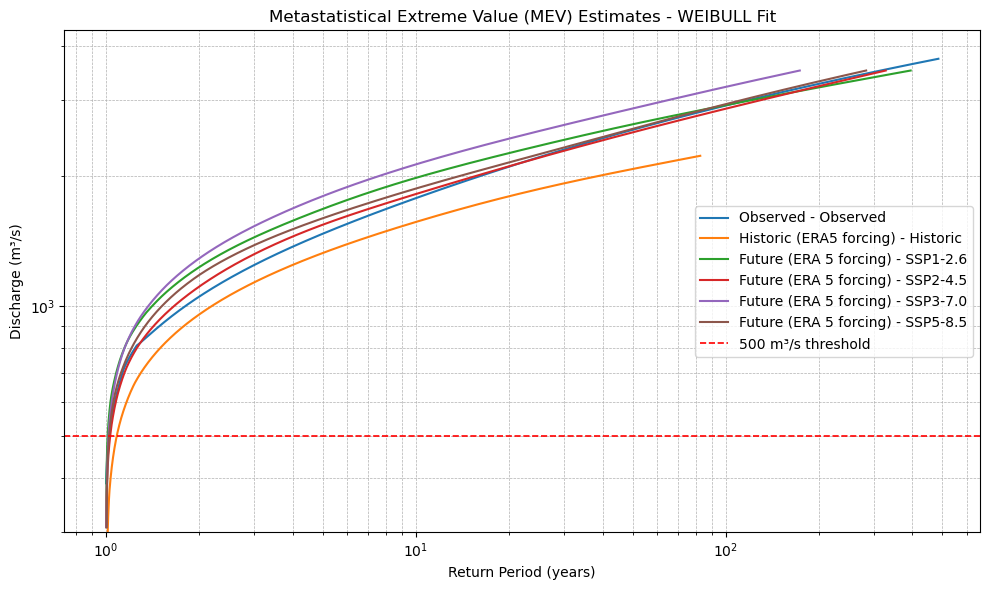

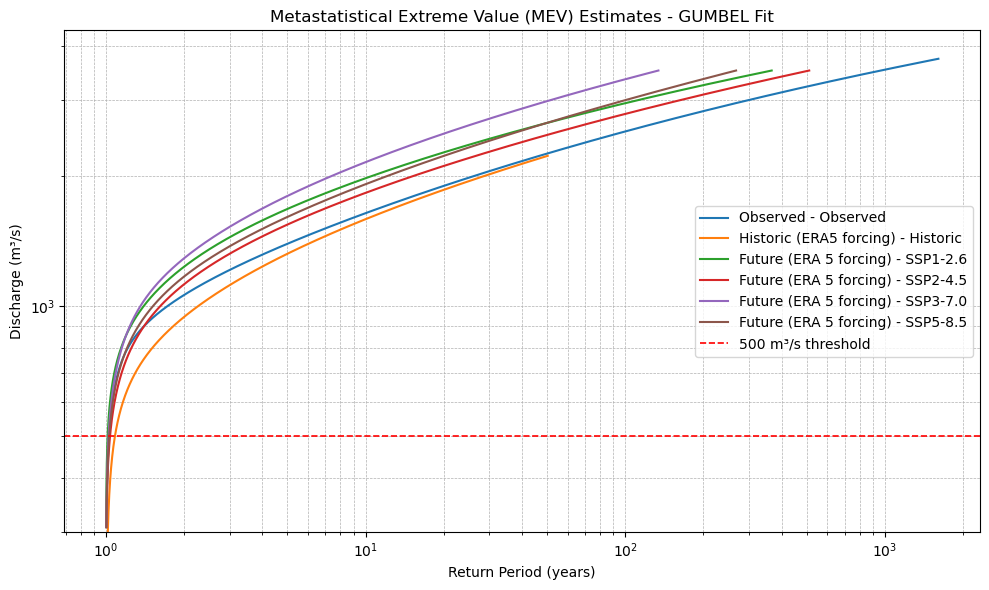

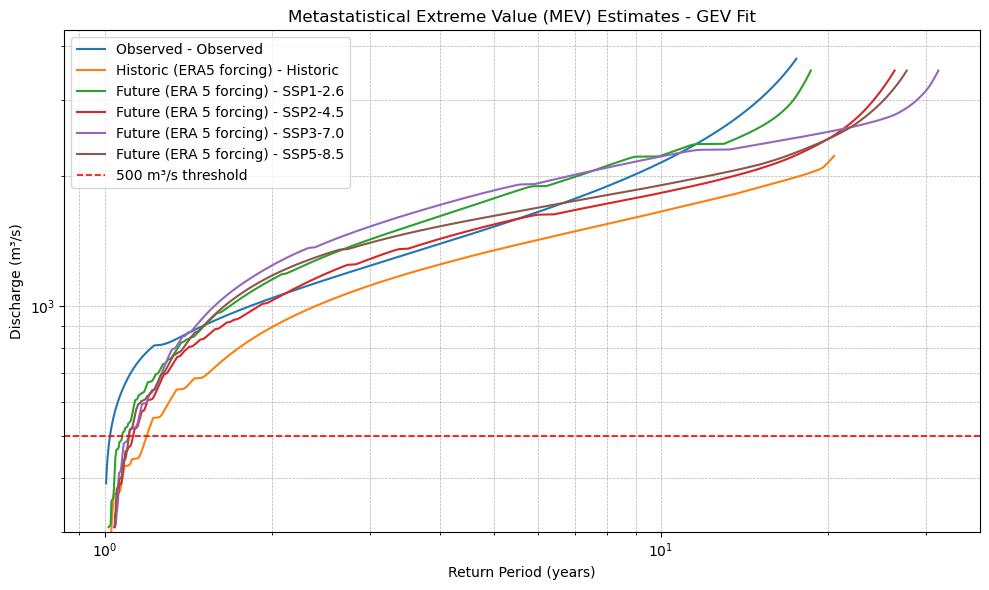

In [10]:
# Run MEV Analysis and Plot for all distributions
for dist in ['weibull', 'gumbel', 'gev']:
    xr_mev_obs = calculate_mev(xr_observed, dist_type=dist)
    xr_mev_hist = calculate_mev(xr_historic, dist_type=dist)
    xr_mev_fut = calculate_mev(xr_future, dist_type=dist)
    plot_mev(xr_mev_obs, xr_mev_hist, xr_mev_fut, dist_type=dist, labels=['Observed', 'Historic (ERA5 forcing)', 'Future (ERA 5 forcing)'])


## Number of drought events by scenario

This section compares the frequency of drought events across different climate scenarios and time periods, categorized into caution, risk, and critical severity levels. This comparison highlights differences in drought occurrence across observed, historical, and future discharge time series. The historical and future scenarios are based on CMIP model runs that were adjusted using ERA5 forcing data. The aim is to evaluate how the occurrence of low-flow conditions evolves under changing climatic conditions. 

Please note that each scenario covers a different time span:

- **Observed:** 2013–2019  
- **Historic:** 1990–2014  
- **Future Scenarios:** 2026–2099  

In [11]:
#Input data & collect drought events
scenarios = {
    "Observed": discharge_series,
    "Historic": historic.iloc[:, 0],
    "SSP1-2.6": future.iloc[:, 0],
    "SSP2-4.5": future.iloc[:, 1],
    "SSP3-7.0": future.iloc[:, 2],
    "SSP5-8.5": future.iloc[:, 3]
}

all_dfs = []
for name, series in scenarios.items():
    df = droughts(series, basin_name=name, q_crit=500)
    df["Scenario"] = name
    all_dfs.append(df)
drought_events_df = pd.concat(all_dfs, ignore_index=True)

In [12]:
# Count raw events per Scenario & Status
raw_counts = (
    drought_events_df
    .groupby(["Scenario", "Status"])
    .size()
    .unstack(fill_value=0)
)

# Ensure all three categories exist (fill missing with 0)
raw_counts = raw_counts.reindex(columns=["caution", "risk", "critical"], fill_value=0)

In [13]:
#Compute time spans (years and n-year blocks)
years_info = {}
for name, series in scenarios.items():
    idx = getattr(series, "index", pd.DatetimeIndex(series))
    total_years = idx.max().year - idx.min().year + 1
    years_info[name] = total_years

years_df = (
    pd.Series(years_info, name="n_years")
      .to_frame()
      .reset_index()
      .rename(columns={"index": "Scenario"})
)
years_df["n_3yr_blocks"] = np.ceil(years_df["n_years"] / 3).astype(int)
years_df["n_10yr_blocks"] = np.ceil(years_df["n_years"] / 10).astype(int)
years_df["n_20yr_blocks"] = np.ceil(years_df["n_years"] / 20).astype(int)

In [14]:
#Merge & compute per-year and per-n-year rates
summary = raw_counts.reset_index().merge(years_df, on="Scenario", how="left")
for cat in ["caution", "risk", "critical"]:
    summary[f"{cat}_per_year"] = summary[cat] / summary["n_years"]
    summary[f"{cat}_per_3yrs"] = summary[cat] / summary["n_3yr_blocks"]
    summary[f"{cat}_per_10yrs"] = summary[cat] / summary["n_10yr_blocks"]
    summary[f"{cat}_per_20yrs"] = summary[cat] / summary["n_20yr_blocks"]

In [15]:
#Display summary tables
# Create HTML strings for each table
table1 = summary[["Scenario", "caution_per_year", "risk_per_year", "critical_per_year"]].to_html(index=False)
table2 = summary[["Scenario", "n_years", "n_3yr_blocks", "caution_per_3yrs", "risk_per_3yrs", "critical_per_3yrs"]].to_html(index=False)
table3 = summary[["Scenario", "n_years", "n_10yr_blocks", "caution_per_10yrs", "risk_per_10yrs", "critical_per_10yrs"]].to_html(index=False)
table4 = summary[["Scenario", "n_years", "n_20yr_blocks", "caution_per_20yrs", "risk_per_20yrs", "critical_per_20yrs"]].to_html(index=False)

#2x2 layout
html_output = f"""
<h4>Droughts per year by scenario and category:</h4>
<div style="display: flex; gap: 20px;">
  <div style="flex: 1">{table1}</div>
  <div style="flex: 1">{table2}</div>
</div>

<h4>Droughts per 10-year and 20-year block by scenario and category:</h4>
<div style="display: flex; gap: 20px;">
  <div style="flex: 1">{table3}</div>
  <div style="flex: 1">{table4}</div>
</div>
"""

# Display
display(HTML(html_output))

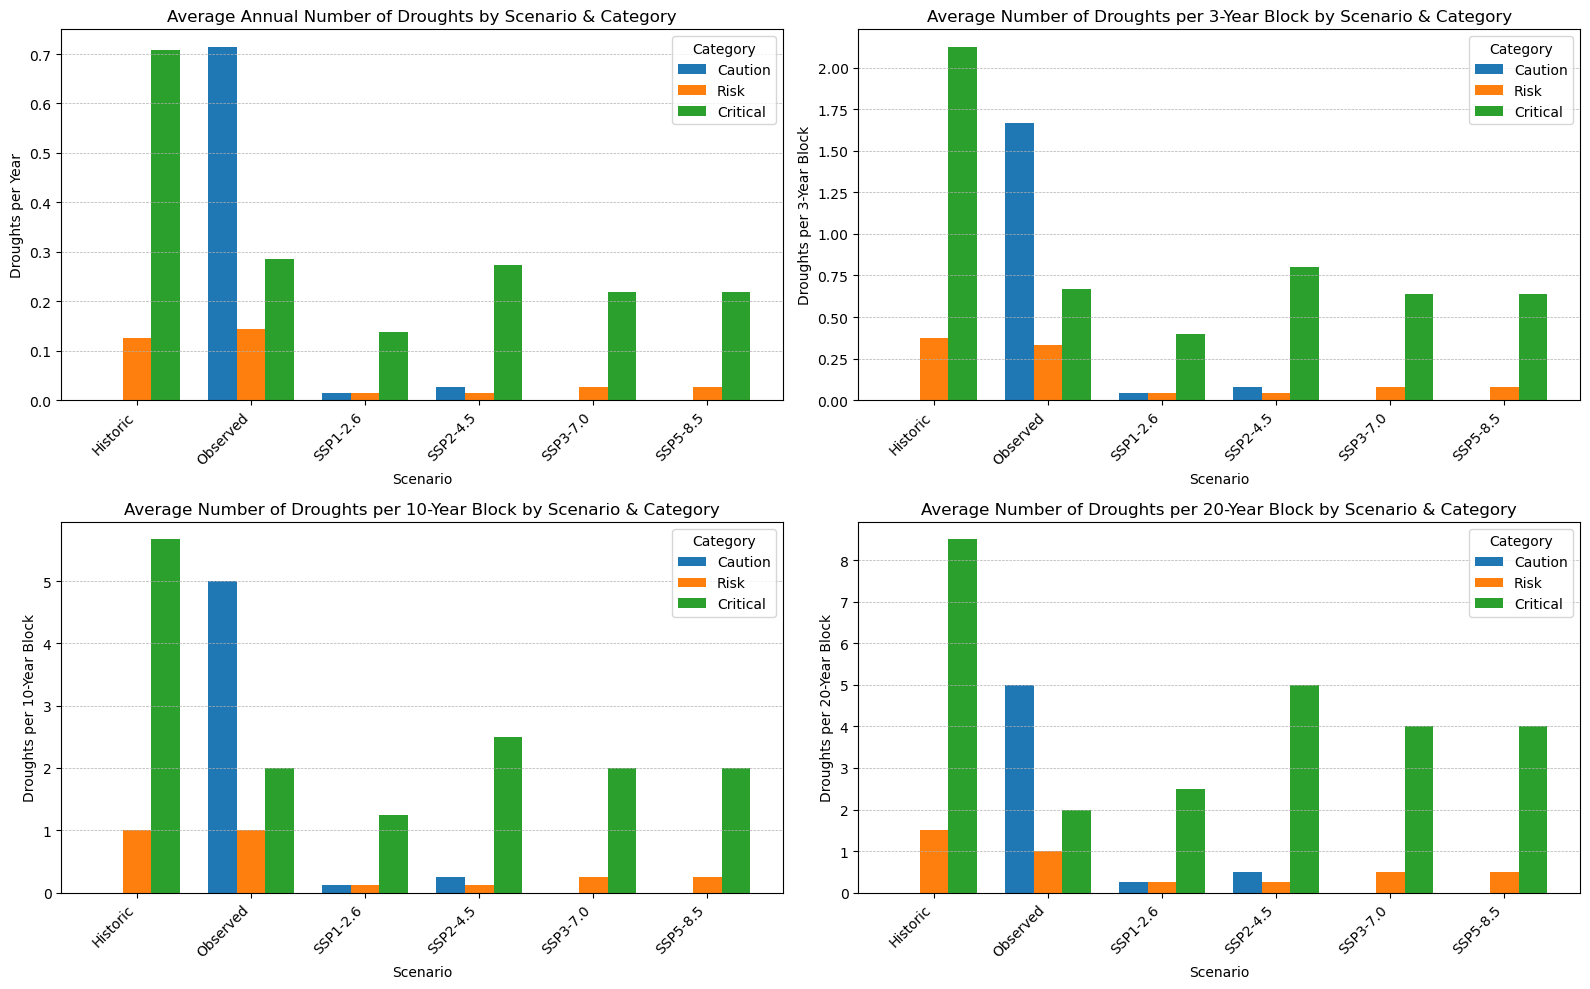

In [16]:
#Plot
plot_configs = [
    {
        "cols": ["caution_per_year", "risk_per_year", "critical_per_year"],
        "title": "Average Annual Number of Droughts by Scenario & Category",
        "ylabel": "Droughts per Year"
    },
    {
        "cols": ["caution_per_3yrs", "risk_per_3yrs", "critical_per_3yrs"],
        "title": "Average Number of Droughts per 3-Year Block by Scenario & Category",
        "ylabel": "Droughts per 3-Year Block"
    },
    {
        "cols": ["caution_per_10yrs", "risk_per_10yrs", "critical_per_10yrs"],
        "title": "Average Number of Droughts per 10-Year Block by Scenario & Category",
        "ylabel": "Droughts per 10-Year Block"
    },
    {
        "cols": ["caution_per_20yrs", "risk_per_20yrs", "critical_per_20yrs"],
        "title": "Average Number of Droughts per 20-Year Block by Scenario & Category",
        "ylabel": "Droughts per 20-Year Block"
    }
]

n = len(summary)
x = np.arange(n)
width = 0.25

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for ax, cfg in zip(axes, plot_configs):
    ax.bar(x - width, summary[cfg["cols"][0]], width, label="Caution")
    ax.bar(x        , summary[cfg["cols"][1]], width, label="Risk")
    ax.bar(x + width, summary[cfg["cols"][2]], width, label="Critical")

    ax.set_title(cfg["title"])
    ax.set_xlabel("Scenario")
    ax.set_ylabel(cfg["ylabel"])
    ax.set_xticks(x)
    ax.set_xticklabels(summary["Scenario"], rotation=45, ha="right")
    ax.legend(title="Category")
    ax.grid(True, axis="y", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()